### Imports and Dependencies

This section imports various essential libraries and modules needed for building and training a deep learning model. 

- **os**: Provides functions to interact with the operating system, such as file handling.
- **keras.backend as K**: Keras backend functions, offering an interface for low-level tensor operations, allowing seamless switching between TensorFlow, Theano, and CNTK backends.
- **numpy as np**: Numpy library, used for numerical operations on arrays and matrices.
- **tensorflow as tf**: TensorFlow library, the primary deep learning framework used.
- **keras.applications.vgg16.VGG16**: Imports the VGG16 model, a pre-trained convolutional neural network often used for image recognition tasks.
- **keras.layers**: Imports various Keras layers that are commonly used in building deep learning models:
  - `Activation`, `Add`, `BatchNormalization`, `Conv2D`, `Dense`, `Dropout`, `Flatten`, `Input`, `Lambda`, `Layer`, `LeakyReLU`, `UpSampling2D`
- **keras.models.Model**: Used for defining and creating Keras models.
- **PIL.Image**: Provides functions for image processing, such as opening and manipulating images.
- **tensorflow.python.keras.utils.conv_utils**: Utility functions for convolution operations in Keras.


In [1]:
# layer_utils imports
import os
import shutil
import random

import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    InputSpec,
    Lambda,
    Layer,
    LeakyReLU,
    UpSampling2D,
)
from keras.models import Model
from PIL import Image
from tensorflow.python.keras.utils import conv_utils

## Residual Block Function

This function defines a **ResNet block** using Keras' Sequential API. A ResNet block is a fundamental building block of the ResNet architecture, which allows for the construction of very deep neural networks by enabling shortcut connections, thus helping to mitigate the vanishing gradient problem.

### Parameters:
- **input**: The input tensor to the ResNet block.
- **filters**: Number of filters to be used in the convolutional layers.
- **kernel_size**: Size of the convolutional kernels (default is `(3, 3)`).
- **strides**: The strides of the convolution along the height and width (default is `(1, 1)`).
- **use_dropout**: Boolean indicating whether to apply dropout after the first activation. Dropout is used to prevent overfitting (default is `False`).

### Function Workflow:
1. **ReflectionPadding2D**: Pads the input tensor to maintain its size after convolution, using reflection padding, which mirrors the border values of the tensor.
2. **Conv2D Layer**: Applies a 2D convolution with the specified number of filters, kernel size, and strides.
3. **BatchNormalization**: Normalizes the activations of the previous layer to stabilize the learning process and reduce overfitting.
4. **Activation**: Applies a ReLU (Rectified Linear Unit) activation function to introduce non-linearity.
5. **Dropout** *(optional)*: Randomly drops a fraction of input units to prevent overfitting.
6. **Second Conv2D Layer**: Another 2D convolution followed by batch normalization.
7. **Add Layer**: Combines the output of the block with the input using a skip connection, which enables the network to learn identity mappings.

The function returns the output tensor, which is the result of adding the original input to the transformed output, thus forming a residual block.


In [2]:
def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    """
    Instanciate a Keras Resnet Block using sequential API.

    :param input: Input tensor
    :param filters: Number of filters to use
    :param kernel_size: Shape of the kernel for the convolution
    :param strides: Shape of the strides for the convolution
    :param use_dropout: Boolean value to determine the use of dropout
    :return: Keras Model
    """
    x = ReflectionPadding2D((1, 1))(input)
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
    )(x)
    x = BatchNormalization()(x)

    merged = Add()([input, x])
    return merged

### Spatial Reflection 2D Padding Function

This function applies **reflection padding** to a 4D tensor along its 2nd and 3rd dimensions. Reflection padding involves mirroring the border values of a tensor, which is particularly useful in image processing tasks where boundary conditions need to be preserved.

#### Parameters:
- **x**: The input tensor, which is expected to be 4D (e.g., a batch of images with dimensions `[batch_size, height, width, channels]`).
- **padding**: A tuple defining the amount of padding to apply to the 2nd and 3rd dimensions. Each dimension has a pair of values indicating the padding to be added before and after the respective dimension (default is `((1, 1), (1, 1))`).
- **data_format**: Defines the ordering of dimensions in the input tensor. It can be:
  - `'channels_last'`: Typical format for TensorFlow, where the tensor shape is `[batch_size, height, width, channels]`.
  - `'channels_first'`: Typical format for Theano, where the tensor shape is `[batch_size, channels, height, width]`.
  If not provided, the function defaults to the current Keras backend's image data format.

#### Function Workflow:
1. **Input Validation**: 
   - Ensures that the `padding` parameter is correctly specified as a tuple of two pairs.
   - Confirms that the `data_format` is either `'channels_first'` or `'channels_last'`.
  
2. **Padding Pattern Creation**:
   - Based on the `data_format`, constructs a padding pattern that specifies how much padding to apply to each dimension of the tensor.

3. **Tensor Padding**:
   - Applies the reflection padding to the input tensor using TensorFlow's `tf.pad` function, which pads the tensor according to the defined pattern.

The function returns a tensor that has been padded along its 2nd and 3rd dimensions using reflection padding.


In [3]:
def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.

    :param x: Input tensor
    :param padding: Shape of padding to use
    :param data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    :return: Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = image_data_format()
    if data_format not in {"channels_first", "channels_last"}:
        raise ValueError("Unknown data_format " + str(data_format))

    if data_format == "channels_first":
        pattern = [[0, 0], [0, 0], list(padding[0]), list(padding[1])]
    else:
        pattern = [[0, 0], list(padding[0]), list(padding[1]), [0, 0]]
    return tf.pad(x, pattern, "REFLECT")

## ReflectionPadding2D Layer

The `ReflectionPadding2D` class defines a custom Keras layer that applies reflection padding to 2D inputs, such as images. Reflection padding involves mirroring the edges of the input tensor, which can be beneficial in convolutional neural networks (CNNs) to reduce border artifacts and improve the generalization of the model.

### Arguments:
- **padding**: Specifies the amount of padding to be applied:
  - **int**: Applies the same symmetric padding to both the width and height.
  - **tuple of 2 ints**: Different symmetric padding values for height and width `(symmetric_height_pad, symmetric_width_pad)`.
  - **tuple of 2 tuples of 2 ints**: Specific padding for each side of the image: `((top_pad, bottom_pad), (left_pad, right_pad))`.
- **data_format**: Specifies the order of dimensions in the input tensor. Options are:
  - `'channels_last'`: Format where the input shape is `(batch, height, width, channels)`.
  - `'channels_first'`: Format where the input shape is `(batch, channels, height, width)`. It defaults to the Keras configuration value.

### Input Shape:
- 4D tensor with one of the following shapes depending on the data format:
  - `'channels_last'`: `(batch, rows, cols, channels)`
  - `'channels_first'`: `(batch, channels, rows, cols)`

### Output Shape:
- 4D tensor with the padded dimensions:
  - `'channels_last'`: `(batch, padded_rows, padded_cols, channels)`
  - `'channels_first'`: `(batch, channels, padded_rows, padded_cols)`

### Functionality:
1. **Initialization (`__init__`)**: Validates the `padding` input and normalizes it into a consistent format. It also sets the `data_format` based on the provided argument or Keras configuration.
2. **Output Shape Computation (`compute_output_shape`)**: Calculates the shape of the tensor after padding has been applied, based on the input shape and padding values.
3. **Forward Pass (`call`)**: Applies reflection padding to the input tensor using the `spatial_reflection_2d_padding` function.
4. **Configuration (`get_config`)**: Returns the configuration of the layer, allowing it to be recreated later.

This layer is particularly useful in image processing tasks within CNNs, where edge artifacts can be mitigated through reflection padding, leading to improved model performance.


In [4]:
class ReflectionPadding2D(Layer):
    """Reflection-padding layer for 2D input (e.g. picture).
    This layer can add rows and columns or zeros
    at the top, bottom, left and right side of an image tensor.
    # Arguments
        padding: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
            - If int: the same symmetric padding
                is applied to width and height.
            - If tuple of 2 ints:
                interpreted as two different
                symmetric padding values for height and width:
                `(symmetric_height_pad, symmetric_width_pad)`.
            - If tuple of 2 tuples of 2 ints:
                interpreted as
                `((top_pad, bottom_pad), (left_pad, right_pad))`
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    # Input shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, rows, cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, rows, cols)`
    # Output shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, padded_rows, padded_cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, padded_rows, padded_cols)`
    """

    def __init__(self, padding=(1, 1), data_format=None, **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, "__len__"):
            if len(padding) != 2:
                raise ValueError(
                    "`padding` should have two elements. " "Found: " + str(padding)
                )
            height_padding = conv_utils.normalize_tuple(
                padding[0], 2, "1st entry of padding"
            )
            width_padding = conv_utils.normalize_tuple(
                padding[1], 2, "2nd entry of padding"
            )
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError(
                "`padding` should be either an int, "
                "a tuple of 2 ints "
                "(symmetric_height_pad, symmetric_width_pad), "
                "or a tuple of 2 tuples of 2 ints "
                "((top_pad, bottom_pad), (left_pad, right_pad)). "
                "Found: " + str(padding)
            )
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == "channels_first":
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0], input_shape[1], rows, cols)
        elif self.data_format == "channels_last":
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0], rows, cols, input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(
            inputs, padding=self.padding, data_format=self.data_format
        )

    def get_config(self):
        config = {"padding": self.padding, "data_format": self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Model Construction and Summary with Reflection Padding


### Code Explanation:
1. **Input Layer**:
   - The `Input` layer is defined with a shape of `(256, 256, 3)`, indicating that the model expects input images of size 256x256 with 3 color channels (e.g., RGB).

2. **ReflectionPadding2D Layer**:
   - The `ReflectionPadding2D` layer is applied to the input tensor with a padding of 3. This adds 3 pixels of padding to all sides of the image using reflection padding, resulting in an output tensor with dimensions `(262, 262, 3)`.

3. **Model Definition**:
   - The `Model` is created by specifying the input tensor and the output tensor (`x`), which has undergone reflection padding.

4. **Model Summary**:
   - The `model.summary()` function prints out a summary of the model, detailing each layer, its output shape, and the number of parameters.


In [5]:
input = Input(shape=(256, 256, 3))
x = ReflectionPadding2D(3)(input)
model = Model(input, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reflection_padding2d                 │ (None, 262, 262, 3)         │               0 │
│ (ReflectionPadding2D)                │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Loss Functions for Image Processing

### Perceptual Loss
- **Perceptual Loss** measures the difference between high-level features of the true and predicted images. These features are extracted from an intermediate layer of a pre-trained network like VGG16. Instead of focusing on pixel-wise differences, perceptual loss compares how similar the images are in terms of content and style in the feature space. This loss is particularly effective in image generation tasks, ensuring that generated images are visually appealing and closer to human perception.

### Wasserstein Loss
- **Wasserstein Loss** is used primarily in Generative Adversarial Networks (GANs), particularly in Wasserstein GANs (WGANs). This loss function aims to measure the distance between the distributions of the generated and real data, helping stabilize training. Unlike traditional GAN losses that suffer from vanishing gradients, Wasserstein Loss provides meaningful gradients even when the generator's performance is poor, leading to more stable training and better quality outputs.

### Gradient Penalty Loss
- **Gradient Penalty** Loss is used in Wasserstein GANs with Gradient Penalty (WGAN-GP) to enforce the Lipschitz constraint, which is crucial for the stability of the Wasserstein distance. This loss penalizes the model when the gradient norm moves away from the value of 1. By ensuring that the gradients have a norm close to 1, this loss helps prevent mode collapse and improves the overall stability and performance of GANs.

In [6]:
# Note: The image shape must be multiple of patch_shape
image_shape = (256, 256, 3)

In [7]:
def l1_loss(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

In [8]:
def perceptual_loss_100(y_true, y_pred):
    return 100 * perceptual_loss(y_true, y_pred)

In [9]:
image_shape = (256, 256, 3)  # Replace with your actual image shape
vgg = VGG16(include_top=False, weights="imagenet", input_shape=image_shape)
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
loss_model.trainable = False  # Freeze the VGG16 layers

In [10]:
def perceptual_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(loss_model(y_true) - loss_model(y_pred)))

In [11]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [12]:
def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(
        gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))
    )

    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)

    return tf.reduce_mean(gradient_penalty)

### **Hyperparameters and Input Shapes**

- **channel_rate**: Set to 64, this parameter represents the number of channels or filters used in the convolutional layers within the network. It defines the base filter size used across the model's layers.
  
- **image_shape**: Defined as `(256, 256, 3)`, it specifies the shape of the input images, where 256x256 are the dimensions, and 3 represents the RGB color channels. It is important that the image shape is a multiple of `patch_shape` to ensure compatibility with the network's architecture.

- **patch_shape**: With the shape `(64, 64, 3)`, this defines the size of the patches extracted from the input image. Each patch has a size of 64x64 pixels and 3 color channels.

- **ngf**: Set to 64, this parameter stands for "Number of Generator Filters" and represents the base number of filters in the generator's first convolutional layer. The value may be doubled in subsequent layers.

- **ndf**: Also set to 64, this parameter is the "Number of Discriminator Filters" and represents the base number of filters in the discriminator's first convolutional layer.

- **input_nc**: Defined as 3, it represents the number of input channels for the generator, corresponding to the RGB channels of the input image.

- **output_nc**: Also set to 3, it represents the number of output channels from the generator, which typically matches the input channels for color images.

- **input_shape_generator**: `(256, 256, 3)` defines the input shape for the generator, indicating that the generator takes images with a size of 256x256 pixels and 3 color channels.

- **input_shape_discriminator**: `(256, 256, 3)` defines the input shape for the discriminator, indicating that the discriminator processes images with a size of 256x256 pixels and 3 color channels.

- **n_blocks_gen**: Set to 9, this parameter specifies the number of residual blocks within the generator. Residual blocks are used to help the model learn more complex functions by allowing the flow of gradients through skip connections.


In [13]:
# the paper defined hyper-parameter:chr
channel_rate = 64
# Note the image_shape must be multiple of patch_shape
image_shape = (256, 256, 3)
patch_shape = (channel_rate, channel_rate, 3)

ngf = 64
ndf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
input_shape_discriminator = (256, 256, output_nc)
n_blocks_gen = 9

### **Generator Model Architecture**

The `generator_model` function defines the architecture of the generator in a GAN (Generative Adversarial Network). The generator is designed to take an input image and produce a modified version of that image.

#### **Architecture Breakdown**:

- **Inputs**: 
  - The model accepts an image with a shape defined by `image_shape`, which is `(256, 256, 3)`.

- **Initial Layers**:
  - **ReflectionPadding2D**: Applies reflection padding to the input image to maintain the image dimensions before convolution.
  - **Conv2D**: A 2D convolutional layer with `ngf` (64) filters and a kernel size of `(7, 7)` is applied, followed by batch normalization and a ReLU activation function.

- **Downsampling**:
  - Two downsampling layers are applied sequentially, each reducing the spatial dimensions of the image by half (due to stride of 2), while doubling the number of filters.

- **Residual Blocks**:
  - **n_blocks_gen** (9) residual blocks are added, each consisting of two convolutional layers with batch normalization and ReLU activation. Dropout is applied within these blocks to prevent overfitting.

- **Upsampling**:
  - Two upsampling layers are applied to reverse the downsampling process, increasing the spatial dimensions back to the original size while halving the number of filters.

- **Final Layers**:
  - After another reflection padding and convolutional operation (with a kernel size of `(7, 7)`), a `tanh` activation function is used to scale the output values between -1 and 1.
  - An `Add` layer combines the generated output with the original input to create the final output image.

- **Output**:
  - The output image is scaled down by dividing by 2 using a `Lambda` layer.

In [14]:
def generator_model():
    """Build generator architecture."""
    # Current version : ResNet block
    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(
            filters=ngf * mult * 2, kernel_size=(3, 3), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf * mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2 ** (n_downsampling - i)
        # x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3, 3), strides=2, padding='same')(x)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding="valid")(x)
    x = Activation("tanh")(x)

    outputs = Add()([x, inputs])
    # outputs = Lambda(lambda z: K.clip(z, -1, 1))(x)
    outputs = Lambda(lambda z: z / 2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name="Generator")
    return model

### **Discriminator Model Architecture**

The `discriminator_model` function defines the architecture of the discriminator in a GAN (Generative Adversarial Network). The discriminator's role is to distinguish between real images and images generated by the generator.

#### **Architecture Breakdown**:

- **Inputs**: 
  - The model accepts an image with a shape defined by `input_shape_discriminator`, which is `(256, 256, 3)`.

- **Initial Convolutional Layer**:
  - **Conv2D**: A 2D convolutional layer with `ndf` (64) filters and a kernel size of `(4, 4)` is applied, using a stride of 2 to reduce the image dimensions. This is followed by a LeakyReLU activation function with a negative slope of 0.2, allowing small gradients when the unit is not active.

- **Intermediate Convolutional Layers**:
  - **n_layers** (3) layers are applied sequentially, where each layer:
    - Doubles the number of filters up to a maximum of 512.
    - Applies a convolutional layer with a kernel size of `(4, 4)` and a stride of 2 to further downsample the image.
    - Includes batch normalization to stabilize and speed up the training.
    - Uses LeakyReLU activation to introduce non-linearity.

- **Final Convolutional Layer**:
  - A final convolutional layer with a single filter is applied, which outputs a feature map that is then flattened.

- **Output Layers**:
  - **Dense Layers**: The flattened output is passed through a dense layer with 1024 units and a `tanh` activation function.
  - **Output**: The final dense layer outputs a single value using a `sigmoid` activation function, representing the probability that the input image is real (as opposed to generated).

- **Activation Option**:
  - The model includes an option (`use_sigmoid`) to apply a sigmoid activation function directly after the last convolutional layer if needed.

In [15]:
def discriminator_model():
    """Build discriminator architecture."""
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(
            filters=ndf * nf_mult, kernel_size=(4, 4), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf * nf_mult, kernel_size=(4, 4), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding="same")(x)
    if use_sigmoid:
        x = Activation("sigmoid")(x)

    x = Flatten()(x)
    x = Dense(1024, activation="tanh")(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=x, name="Discriminator")
    return model

### **Combined Generator and Discriminator Model**

The `generator_containing_discriminator` function creates a model that combines both the generator and the discriminator. This model is used during the training of the generator in a GAN (Generative Adversarial Network).

#### **Function Workflow**:

- **Inputs**:
  - The model takes an input image with a shape defined by `image_shape`, typically `(256, 256, 3)`.

- **Generator**:
  - The input image is first passed through the generator network, which generates a synthetic image.

- **Discriminator**:
  - The generated image is then fed into the discriminator network, which outputs a probability score indicating whether the image is real or fake.

- **Model**:
  - The function returns a combined model that starts with the generator and ends with the discriminator. The model takes an input image and produces an output score from the discriminator.

This combined model is typically used during the training of the generator, where the generator tries to fool the discriminator by generating images that are as realistic as possible.


In [16]:
def generator_containing_discriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model

## Generator and Discriminator Models summary/layout

In [18]:
g = generator_model()
g.summary()
d = discriminator_model()
d.summary()
m = generator_containing_discriminator(generator_model(), discriminator_model())
m.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reflection_padding2d_1        │ (None, 262, 262, 3)       │               0 │ input_layer_2[0][0]        │
│ (ReflectionPadding2D)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           9,472 │ reflection_padding2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 128)     │             512 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 256)       │           1,024 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 64, 64, 256)       │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reflection_padding2d_2        │ (None, 66, 66, 256)       │               0 │ activation_2[0][0]         │
│ (ReflectionPadding2D)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ reflection_padding2d_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 256)       │           1,024 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 11,399,171 (43.48 MB)

 Trainable params: 11,388,675 (43.44 MB)

 Non-trainable params: 10,496 (41.00 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 64, 64, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 1)           │           8,193 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,098,370 (11.82 MB)

 Trainable params: 3,096,450 (11.81 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Generator (Functional)               │ (None, 256, 256, 3)         │      11,399,171 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Discriminator (Functional)           │ (None, 1)                   │       3,098,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,497,541 (55.30 MB)

 Trainable params: 14,485,125 (55.26 MB)

 Non-trainable params: 12,416 (48.50 KB)

### **Image Processing Utility Functions**

This section contains utility functions for loading, preprocessing, and saving images, as well as logging training progress in Keras.

#### **RESHAPE**
- `RESHAPE = (256, 256)`: This constant defines the target shape to which all images will be resized during preprocessing.

#### **is_an_image_file(filename)**
- **Purpose**: Checks if a given file is an image based on its extension.
- **Returns**: `True` if the file is a `.png`, `.jpg`, or `.jpeg` image; otherwise, `False`.


In [19]:
RESHAPE = (256, 256)

In [20]:
def is_an_image_file(filename):
    IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False

#### **list_image_files(directory)**
- **Purpose**: Lists all image files in a specified directory.
- **Returns**: A list of paths to image files.


In [21]:
def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]

#### **load_image(path)**
- **Purpose**: Loads an image from a specified path.
- **Returns**: A PIL image object.


In [22]:
def load_image(path):
    img = Image.open(path)
    return img

#### **preprocess_image(cv_img)**
- **Purpose**: Resizes the image to the `RESHAPE` dimensions and normalizes the pixel values to the range `[-1, 1]`.
- **Returns**: A preprocessed NumPy array representing the image.


In [23]:
def preprocess_image(cv_img):
    cv_img = cv_img.resize(RESHAPE)
    img = np.array(cv_img)
    img = (img - 127.5) / 127.5
    return img

#### **deprocess_image(img)**
- **Purpose**: Converts a normalized image (with pixel values in the range `[-1, 1]`) back to the standard range `[0, 255]`.
- **Returns**: A deprocessed image as a `uint8` NumPy array.


In [24]:
def deprocess_image(img):
    img = img * 127.5 + 127.5
    return img.astype("uint8")

#### **save_image(np_arr, path)**
- **Purpose**: Saves a NumPy array as an image file.
- **Process**: The array is converted back to pixel values in the range `[0, 255]`, and then saved to the specified path using PIL.


In [25]:
def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)

#### **load_images(path, n_images)**
- **Purpose**: Loads and preprocesses a set number of images from directories `A` and `B` within a given path.
- **Returns**: A dictionary containing:
  - `"A"`: A NumPy array of images from directory `A`.
  - `"A_paths"`: A list of the corresponding file paths for the images in `A`.
  - `"B"`: A NumPy array of images from directory `B`.
  - `"B_paths"`: A list of the corresponding file paths for the images in `B`.


In [26]:
def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")
    A_paths, B_paths = os.path.join(path, "A"), os.path.join(path, "B")
    all_A_paths, all_B_paths = list_image_files(A_paths), list_image_files(B_paths)
    images_A, images_B = [], []
    images_A_paths, images_B_paths = [], []
    for path_A, path_B in zip(all_A_paths, all_B_paths):
        img_A, img_B = load_image(path_A), load_image(path_B)
        images_A.append(preprocess_image(img_A))
        images_B.append(preprocess_image(img_B))
        images_A_paths.append(path_A)
        images_B_paths.append(path_B)
        if len(images_A) > n_images - 1:
            break

    return {
        "A": np.array(images_A),
        "A_paths": np.array(images_A_paths),
        "B": np.array(images_B),
        "B_paths": np.array(images_B_paths),
    }

#### **write_log(callback, names, logs, batch_no)**
- **Purpose**: Logs training metrics for Keras using TensorFlow's summary writer.
- **Process**: For each metric (name-value pair), it writes a summary to the callback's writer and flushes the writer to ensure the logs are saved.


In [27]:
def write_log(callback, names, logs, batch_no):
    """
    Util to write callback for Keras training
    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

# Training Phase

### Imported Libraries
- **`datetime`**: Provides classes for manipulating dates and times.
- **`click`**: A package used to create command-line interfaces.
- **`tqdm`**: A library for displaying progress bars in loops.
- **`TensorBoard`** (from `keras.callbacks`): Used for visualizing training metrics in TensorBoard.
- **`Adam`** (from `keras.optimizers`): An optimization algorithm that adapts learning rates during training.


In [28]:
import datetime

import click
import tqdm
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

In [29]:
BASE_DIR = "weights/"

## Function: `save_all_weights`
### Purpose
This function saves the weights of the generator and discriminator models to files. It organizes the saved weights into directories based on the current date and includes epoch number and loss information in the filenames.
### Parameters
- **`d`**: The discriminator model whose weights are to be saved.
- **`g`**: The generator model whose weights are to be saved.
- **`epoch_number`**: The current epoch number, used to name the weight files.
- **`current_loss`**: The current loss value, used to name the weight files.

In [30]:
def save_all_weights(d, g, epoch_number, current_loss):
    now = datetime.datetime.now()
    save_dir = os.path.join(BASE_DIR, "{}{}".format(now.month, now.day))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    g.save_weights(
        os.path.join(save_dir, "generator_{}_{}.h5".format(epoch_number, current_loss)),
        True,
    )
    d.save_weights(
        os.path.join(save_dir, "discriminator_{}.h5".format(epoch_number)), True
    )

## Function: `train_multiple_outputs`

### Purpose
This function trains a Generative Adversarial Network (GAN) with multiple outputs, including both a generator and a discriminator. It handles the training process for both models, logs the losses, and saves the model weights at each epoch.

### Parameters
- **`n_images`**: The number of images to load for training.
- **`batch_size`**: The number of images per batch for training.
- **`log_dir`**: Directory where TensorBoard logs are saved (though not used directly in the function).
- **`epoch_num`**: The number of epochs for training.
- **`critic_updates`**: Number of updates for the discriminator per generator update.

### Functionality
1. **Load Training Data**: Uses `load_images` to load images for training. `x_train` contains input images, and `y_train` contains target images.
2. **Model Initialization**:
   - Initializes the generator (`g`) and discriminator (`d`) models.
   - Creates a combined model (`d_on_g`) that includes both the generator and the discriminator.
3. **Optimizer Setup**:
   - Configures optimizers for both the discriminator and the combined model (`d_on_g`).
4. **Model Compilation**:
   - Compiles the discriminator with the Wasserstein loss function.
   - Compiles the combined model with perceptual and Wasserstein losses.
5. **Training Loop**:
   - Iterates through epochs and batches of data.
   - Trains the discriminator with real and generated images.
   - Trains the combined model using the current batch of images.
   - Logs the average losses to a text file and prints them.
6. **Save Weights**: Saves the weights of the generator and discriminator after each epoch using the `save_all_weights` function.

In [31]:
def train_multiple_outputs(n_images, batch_size, log_dir, epoch_num, critic_updates=3):
    data = load_images("./images/train", n_images)
    y_train, x_train = data["B"], data["A"]

    g = generator_model()
    d = discriminator_model()
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    d_opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d_on_g_opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    d.trainable = False
    loss = [perceptual_loss, wasserstein_loss]
    loss_weights = [100, 1]
    d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
    d.trainable = True

    output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones(
        (batch_size, 1)
    )

    log_path = "./logs"
    tensorboard_callback = TensorBoard(log_path)

    for epoch in tqdm.tqdm(range(epoch_num)):
        permutated_indexes = np.random.permutation(x_train.shape[0])

        d_losses = []
        d_on_g_losses = []
        for index in range(int(x_train.shape[0] / batch_size)):
            batch_indexes = permutated_indexes[
                index * batch_size : (index + 1) * batch_size
            ]
            image_blur_batch = x_train[batch_indexes]
            image_full_batch = y_train[batch_indexes]

            generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                d_losses.append(d_loss)

            d.trainable = False

            d_on_g_loss = d_on_g.train_on_batch(
                image_blur_batch, [image_full_batch, output_true_batch]
            )
            d_on_g_losses.append(d_on_g_loss)

            d.trainable = True

        # write_log(tensorboard_callback, ['g_loss', 'd_on_g_loss'], [np.mean(d_losses), np.mean(d_on_g_losses)], epoch_num)
        print(np.mean(d_losses), np.mean(d_on_g_losses))
        with open("log.txt", "a+") as f:
            f.write(
                "{} - {} - {}\n".format(
                    epoch, np.mean(d_losses), np.mean(d_on_g_losses)
                )
            )

        save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))

In [32]:
def train_command(n_images, batch_size, log_dir, epoch_num, critic_updates):
    return train_multiple_outputs(
        n_images, batch_size, log_dir, epoch_num, critic_updates
    )

## Training Parameters

In [ ]:
n_images = 512  # Number of images to load for training
batch_size = 16  # Size of batch
log_dir = True  # Path to the log_dir for Tensorboard
epoch_num = 100  # Number of epochs for training
critic_updates = 3  # Number of discriminator training

In [ ]:
train_command(
    n_images=n_images,
    batch_size=batch_size,
    log_dir=log_dir,
    epoch_num=epoch_num,
    critic_updates=critic_updates,
)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


# Testing Phase

## Function: `test`

### Purpose
The `test` function evaluates the performance of a pre-trained generator model by generating images from test data and saving the results. It compares the generated images with the original and input images by concatenating them horizontally and saving them as PNG files.

### Parameters
- **`batch_size`**: The number of images to process in each batch.

### Functionality
1. **Load Test Data**: Uses `load_images` to load test images from the specified directory. `x_test` contains input images, and `y_test` contains target images.
2. **Initialize and Load Model**:
   - Initializes the generator model (`g`).
   - Loads pre-trained weights for the generator from a specified file.
3. **Generate Images**: Uses the generator to produce images based on the test input images.
4. **Post-Processing**:
   - Converts the generated images, input images, and target images from their processed form to their original form using `deprocess_image`.
5. **Save Results**:
   - Concatenates the target, input, and generated images horizontally.
   - Saves each concatenated image as a PNG file.

# Selcting some Random images for testing purpose

In [ ]:
def select_random_images(folder_a, folder_b, output_folder, num_images=20):

    os.makedirs(output_folder, exist_ok=True)

    image_filenames = sorted(os.listdir(folder_a))

    random_indices = random.sample(range(len(image_filenames)), num_images)

    output_folder_a = os.path.join(output_folder, "A")  # Subfolder for images from A
    output_folder_b = os.path.join(output_folder, "B")  # Subfolder for images from B
    os.makedirs(output_folder_a, exist_ok=True)
    os.makedirs(output_folder_b, exist_ok=True)

    for index in random_indices:
        filename = image_filenames[index]

        image_path_a = os.path.join(folder_a, filename)
        image_path_b = os.path.join(folder_b, filename)

        shutil.copy2(image_path_a, os.path.join(output_folder_a, filename))
        shutil.copy2(image_path_b, os.path.join(output_folder_b, filename))

folder_a = "./images/test/A"
folder_b = "./images/test/B"
output_folder = "./images_less"
num_images_to_select = 100

select_random_images(folder_a, folder_b, output_folder, num_images_to_select)

print(f"Selected and copied {num_images_to_select} random image pairs to {output_folder}")

Selected and copied 100 random image pairs to ./images_less


# Testing on those random Images
## Saving output in two folders, One for viewing and comparing
### Another for calculating PSNR values

In [ ]:
def test(batch_size):
    data = load_images("./images_less", batch_size)  # Use the more general path "./images/test"
    y_test, x_test = data["B"], data["A"]  # Access both sharp and blurred images

    g = generator_model()
    g.load_weights("./weights/generator.h5")

    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test) # deprocess x_test
    y_test = deprocess_image(y_test) # deprocess y_test

    output_dir = "./results"
    output_array_dir = "./results_array"  # Directory for combined images
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_array_dir, exist_ok=True)

    for i in range(generated.shape[0]):
        generated_img = generated[i, :, :, :]
        original_img = y_test[i, :, :, :]  # Use y_test for original sharp image
        blurred_img = x_test[i, :, :, :] # use x_test for original blurred image

        # Save individual generated and original images
        gen_img = Image.fromarray(generated_img.astype(np.uint8))
        gen_img.save(os.path.join(output_dir, f"generated_{i}.png"))

        orig_img = Image.fromarray(original_img.astype(np.uint8))
        orig_img.save(os.path.join(output_dir, f"original_{i}.png"))

        # Combine and save the three images (original sharp, blurred, and generated)
        combined_img = np.concatenate((original_img, blurred_img, generated_img), axis=1) # Correct order
        combined_im = Image.fromarray(combined_img.astype(np.uint8))
        combined_im.save(os.path.join(output_array_dir, f"results_original_blur_generated{i}.png"))

    print(f"Generated, original, and combined images saved in {output_dir}/ and {output_array_dir}/")

In [77]:
batch_size = 100  # Number of images to process

In [78]:
test(batch_size=batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 237s 237s/step
Generated, original, and combined images saved in ./results/ and ./results_array/


# Results

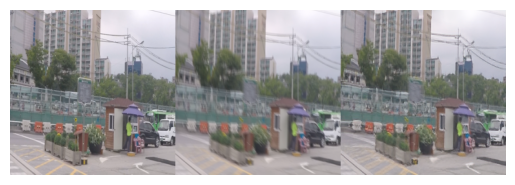

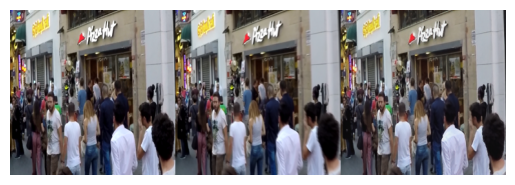

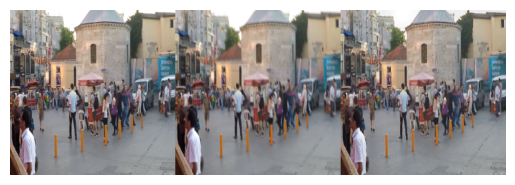

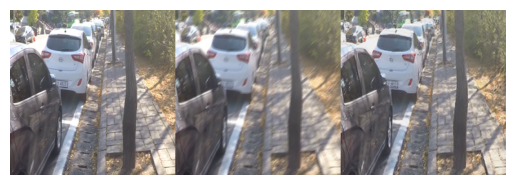

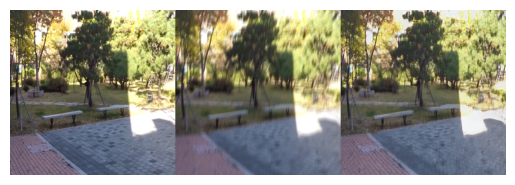

In [83]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt  # Import matplotlib
from IPython.display import display #Import display

folder_path = "./results_array/"  # Replace with your folder path
num_images = 5

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if image_files:
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    for image_file in random_images:
        try:
            image_path = os.path.join(folder_path, image_file)
            img = Image.open(image_path)

            # Option 1: Using matplotlib.pyplot (Recommended for most cases)
            plt.imshow(img)  # Display the image
            plt.axis('off')  # Hide axes (optional)
            plt.show() #Important to use plt.show() to display image.

            # Option 2: Using IPython.display (Alternative)
            # display(img)  # Display the image

        except Exception as e:
            print(f"Error displaying {image_file}: {e}")
else:
    print("No images found")

# Calculation for PSNR values between original sharp image and corresponding Deblurred image

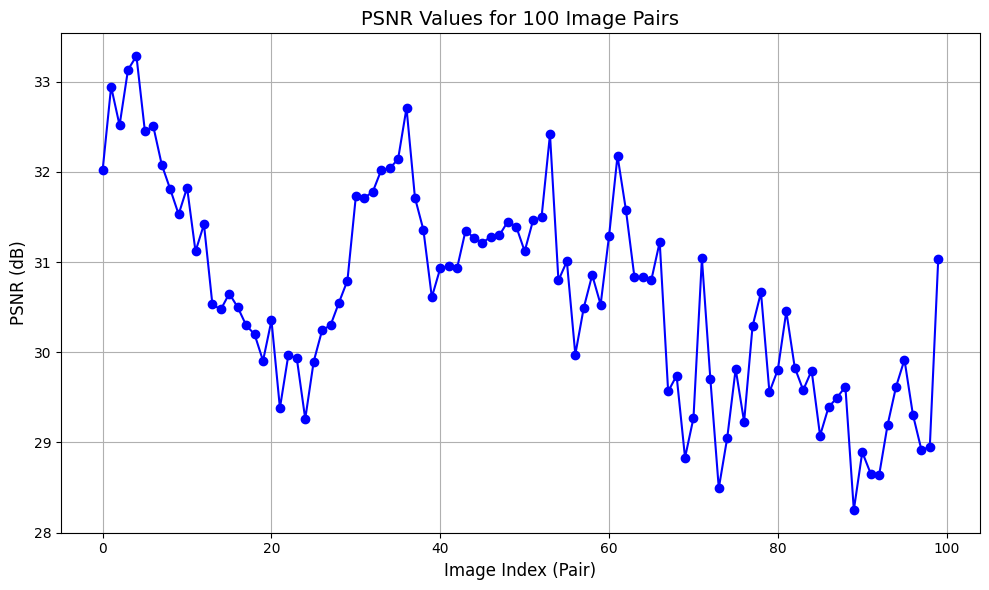

Average PSNR for 100 image pairs: 30.64 dB


In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np


# Function to calculate PSNR
def calculate_psnr(original, deblurred):
    mse = np.mean((original - deblurred) ** 2)
    if mse == 0:
        return float("inf")
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr


# Directory for results (Assuming images are named sequentially)
result_dir = "./results/"

# Number of image pairs
num_images = 100

# List to store PSNR values
psnr_values = []
file_path = "./psnr_values.txt"

# Loop over image pairs (assuming original and generated images are named sequentially)
for i in range(num_images):
    original_path = os.path.join(result_dir, f"original_{i}.png")
    deblurred_path = os.path.join(result_dir, f"generated_{i}.png")

    # Read images in grayscale
    original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    deblurred = cv2.imread(deblurred_path, cv2.IMREAD_GRAYSCALE)

    # Check if images were loaded properly
    if original is None or deblurred is None:
        print(f"Warning: Image pair {i} could not be loaded.")
        continue

    # Calculate PSNR for this image pair
    psnr_value = calculate_psnr(original, deblurred)
    psnr_values.append(psnr_value)

"""# Plot the PSNR values
plt.figure(figsize=(10, 6))
plt.plot(range(len(psnr_values)), psnr_values, marker="o", linestyle="-", color="b")
plt.xlabel("Image Index (Pair)", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.title("PSNR Values for 100 Image Pairs", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()"""

# Print the average PSNR for reference
average_psnr = np.mean(psnr_values)
print(f"Average PSNR for {len(psnr_values)} image pairs: {average_psnr:.2f} dB")

# Write PSNR values to the text file
with open(file_path, "w") as f:
    for psnr in psnr_values:
        f.write(f"{psnr}\n")  # Write each PSNR value on a new line

# Calculating SSIM values

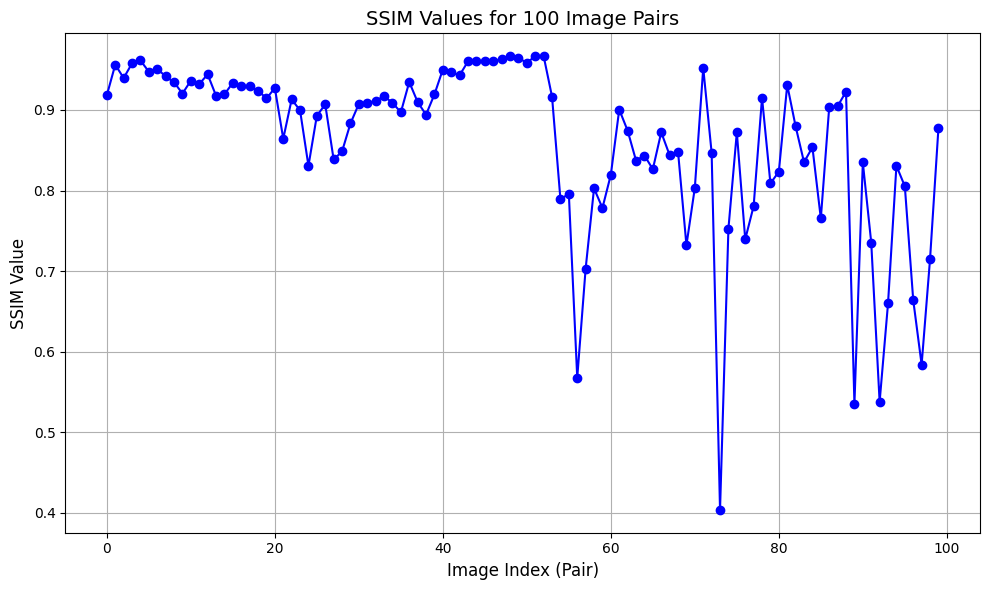

Average SSIM for 100 image pairs: 0.8631


In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim


# Function to calculate SSIM (using scikit-image)
def calculate_ssim(original, deblurred):
    ssim_value = ssim(original, deblurred, data_range=255)  # Assuming 8-bit images
    return ssim_value


# Directory for results
result_dir = "./results/"

# Number of image pairs
num_images = 100

# Lists to store SSIM values
ssim_values = []
file_path = "./ssim_values.txt"

# Loop over image pairs
for i in range(num_images):
    original_path = os.path.join(result_dir, f"original_{i}.png")
    deblurred_path = os.path.join(result_dir, f"generated_{i}.png")

    # Read images in grayscale (important for SSIM)
    original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    deblurred = cv2.imread(deblurred_path, cv2.IMREAD_GRAYSCALE)

    # Check if images were loaded properly
    if original is None or deblurred is None:
        print(f"Warning: Image pair {i} could not be loaded.")
        continue

    # Calculate SSIM for this image pair
    ssim_value = calculate_ssim(original, deblurred)
    ssim_values.append(ssim_value)

"""# Plot the SSIM values
plt.figure(figsize=(10, 6))
plt.plot(range(len(ssim_values)), ssim_values, marker="o", linestyle="-", color="b")
plt.xlabel("Image Index (Pair)", fontsize=12)
plt.ylabel("SSIM Value", fontsize=12)
plt.title("SSIM Values for 100 Image Pairs", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()"""

# Print the average SSIM for reference
average_ssim = np.mean(ssim_values)
print(
    f"Average SSIM for {len(ssim_values)} image pairs: {average_ssim:.4f}"
)  # More decimal places for SSIM

# Write SSIM values to the text file
with open(file_path, "w") as f:
    for ssim_val in ssim_values:
        f.write(f"{ssim_val}\n")

# Plot The PSNR Values and SSIM Values on graph

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load PSNR and SSIM values from text files
psnr_values = np.loadtxt("psnr_values.txt")
ssim_values = np.loadtxt("ssim_values.txt")

# PSNR and SSIM Ranges
psnr_highlights = [
    {"start": 30, "end": 35, "color": "green"},  # Excellent quality
    {"start": 28, "end": 30, "color": "yellow"},  # Good quality
    {"start": 25, "end": 28, "color": "red"},  # Poor quality
]
ssim_highlights = [
    {"start": 0.8, "end": 1.0, "color": "green"},  # High similarity
    {"start": 0.5, "end": 0.8, "color": "yellow"},  # Moderate similarity
    {"start": 0.0, "end": 0.5, "color": "red"},  # Low similarity
]


def format_plot(ax, title, xlabel, ylabel, y_min, y_max, highlights):
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_ylim([y_min, y_max])
    ax.grid(True, linestyle="-", alpha=0.8)
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis="both", which="minor", labelsize=8)

    # Highlight background regions
    for highlight in highlights:
        ax.axhspan(
            highlight["start"],
            highlight["end"],
            facecolor=highlight["color"],
            alpha=0.15,
        )


# Plot PSNR values
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(
    psnr_values, linestyle="--", color="blue", linewidth=1, marker="o", markersize=3
)
ax1.set_yticks(np.arange(25, 36, 1))
ax1.set_xticks(np.arange(0, len(psnr_values) + 1, 10))
ax1.set_xlim(0, len(psnr_values))

format_plot(
    ax1,
    "PSNR(Peak Signal-to-Noise Ratio) Values",
    "Image Index Pair",
    "PSNR (dB)",
    25,
    35,
    psnr_highlights,
)
fig1.tight_layout()
fig1.savefig("psnr.png", dpi=600)

# Plot SSIM values
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(
    ssim_values, linestyle="--", color="green", linewidth=1, marker="o", markersize=3
)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_xticks(np.arange(0, len(ssim_values) + 1, 10))
ax2.set_xlim(0, len(ssim_values))

format_plot(
    ax2,
    "SSIM(Structural Similarity Index) Values",
    "Image Index Pair",
    "SSIM",
    0,
    1,
    ssim_highlights,
)
fig2.tight_layout()
fig2.savefig("ssim.png", dpi=600)

# Display the plots
plt.show()

# Main code ended here, below is work in progres

## THIS CODE WAS FOR A SPECIFIC IMAGE

In [ ]:
import numpy as np
import os
from PIL import Image
from tensorflow.keras.models import load_model

def deprocess_image(img):
    """Convert the image back to uint8 format."""
    img = (img + 1) * 127.5  # Assuming images were normalized between -1 and 1
    return np.clip(img, 0, 255).astype(np.uint8)

def preprocess_image(img_path):
    """Load and preprocess a single image for model input."""
    img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB format
    img = img.resize((256, 256))  # Resize to match model input size (adjust if needed)
    img = np.array(img) / 127.5 - 1  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def deblur_image(image_path):
    """Deblur a specific image."""
    g = generator_model()  # Load the generator model
    g.load_weights("./weights/94/generator.h5")  # Load trained weights

    # Load and preprocess the selected image
    x_test = preprocess_image(image_path)

    # Generate the deblurred image
    generated_image = g.predict(x_test)[0]  # Remove batch dimension
    generated_image = deprocess_image(generated_image)

    # Load original blurry image for comparison
    x_test = deprocess_image(x_test[0])  # Convert back to uint8

    # Save the output
    output = np.concatenate((x_test, generated_image), axis=1)  # Side-by-side comparison
    im = Image.fromarray(output)

    # Create output directory
    output_array_dir = "./results_array1"
    os.makedirs(output_array_dir, exist_ok=True)

    # Save the result
    output_path = os.path.join(output_array_dir, "deblurred_result.png")
    im.save(output_path)

    print(f"Deblurred image saved at: {output_path}")

# Example usage
image_path = "./IMG_4129_blur.jpg"  # Change to your image path
deblur_image(image_path)


FileNotFoundError: [Errno 2] No such file or directory: './IMG_4129_blur.jpg'

In [39]:

# Assuming 'loss_values' and 'val_loss_values' contain training and validation loss per epoch

import matplotlib.pyplot as plt

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


NameError: name 'loss_values' is not defined

Error: Image paths are incorrect.


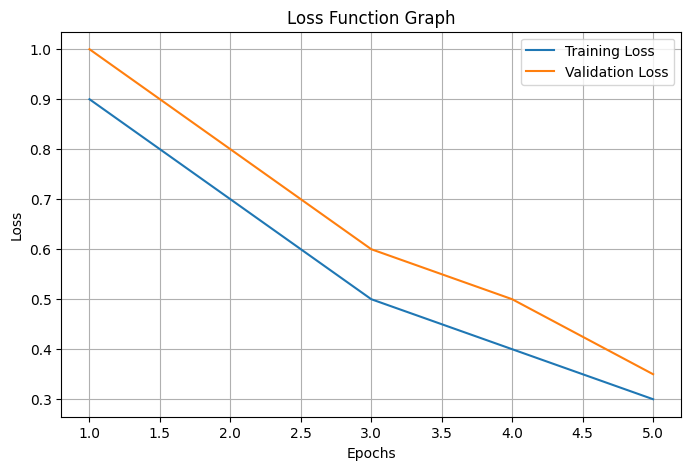

In [82]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# Function to plot loss graph
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Function Graph")
    plt.legend()
    plt.grid()
    plt.show()

# Example loss values (Replace with actual training loss values from your model)
train_loss = [0.9, 0.7, 0.5, 0.4, 0.3]  # Replace with real values
val_loss = [1.0, 0.8, 0.6, 0.5, 0.35]  # Replace with real values

plot_loss(train_loss, val_loss)


In [ ]:
def test(batch_size):
    data = load_images("./images_less", batch_size)  # Use the more general path "./images/test"
    y_test, x_test = data["B"], data["A"]  # Access both sharp and blurred images

    g = generator_model()
    g.load_weights("./weights/94/generator.h5")

    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test) # deprocess x_test
    y_test = deprocess_image(y_test) # deprocess y_test

    output_dir = "./resultsForPaper"
    # output_array_dir = "./results_seperate_3_forpaper"  # Directory for combined images
    os.makedirs(output_dir, exist_ok=True)
    # os.makedirs(output_array_dir, exist_ok=True)

    for i in range(generated.shape[0]):
        generated_img = generated[i, :, :, :]
        original_img = y_test[i, :, :, :]  # Use y_test for original sharp image
        blurred_img = x_test[i, :, :, :] # use x_test for original blurred image

        # Save individual generated and original images and blurred images
        gen_img = Image.fromarray(generated_img.astype(np.uint8))
        gen_img.save(os.path.join(output_dir, f"generated_{i}.png"))

        orig_img = Image.fromarray(original_img.astype(np.uint8))
        orig_img.save(os.path.join(output_dir, f"original_{i}.png"))

        blur_image = Image.fromarray(blurred_img.astype(np.uint8))
        blur_image.save(os.path.join(output_dir, f"blurres_{i}.png"))

        # Combine and save the three images (original sharp, blurred, and generated)
        # combined_img = np.concatenate((original_img, blurred_img, generated_img), axis=1) # Correct order
        # combined_im = Image.fromarray(combined_img.astype(np.uint8))
        # combined_im.save(os.path.join(output_array_dir, f"results_original_blur_generated{i}.png"))

    # print(f"Generated, original, and combined images saved in {output_dir}/ and {output_array_dir}/")

In [ ]:
batch_size = 100  # Number of images to process
test(batch_size=batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 252s 252s/step
